In [15]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [16]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from scipy.stats import norm

from core import multi_evaluate, exp_aggregator, IdentityConv2d
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# CONFIG
ssim = StructuralSimilarityIndexMeasure()
batch_size = 20
num_neurons = 200
data_path = 'data/imagenet'

transforms = Compose([
    Resize(size=256),
    CenterCrop(size=(224, 224)),
    ToTensor()
])


base_dataset = torchvision.datasets.ImageNet(
    root=data_path, split="val", transform=transforms
)

val_loader = DataLoader(base_dataset, batch_size=batch_size, shuffle=True)

In [18]:
def plot20(batch, name=""):
    fig, axs = plt.subplots(4, 5, figsize=(11.5, 9))
    fig.subplots_adjust(hspace=0.1, wspace=0)
    
    img_idx = 0
    for i in range(4):
        for j in range(5):
            axs[i, j].axis('off')  
            
            # Undo normalization
            img = batch[img_idx].permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC format 
            img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
            
            axs[i, j].imshow(img)
            img_idx += 1
    
    plt.axis('off')
    plt.suptitle(name)
    plt.show()

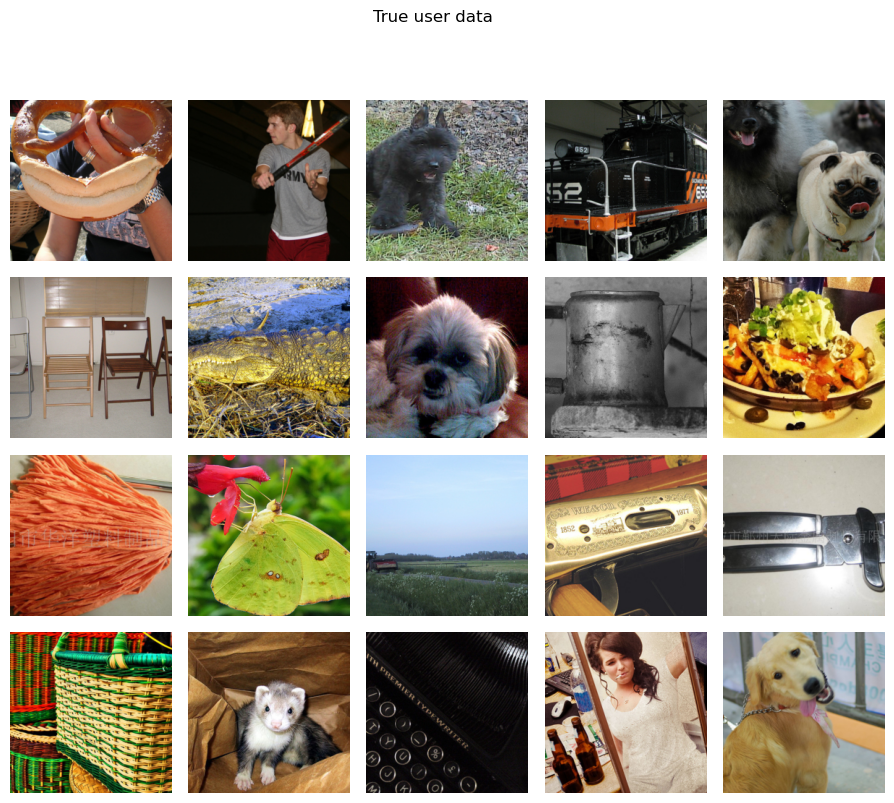

In [19]:
user_data, label = next(iter(val_loader))
plot20(user_data, name="True user data")

In [20]:
device = torch.device("cpu")
layer = nn.Linear(3 * 224 * 224, num_neurons).to(device)
relu = nn.ReLU()
ln = nn.LayerNorm(3 * 224 * 224)

with torch.no_grad():
    layer.weight.data.normal_()
    
# QBI
optimal_bias = norm.ppf(1 / batch_size) * np.sqrt(3 * 224 * 224)
layer.bias.data.fill_(optimal_bias)

x = ln(user_data.flatten(start_dim=1))
x = layer(x)
x = relu(x)
loss = x.mean()
loss.backward()

w_grad = layer.weight.grad.clone()
b_grad = layer.bias.grad.clone()

intermediate = w_grad / b_grad.view(-1, 1)
intermediate = intermediate.reshape(-1, 3, 224, 224).to("cpu")

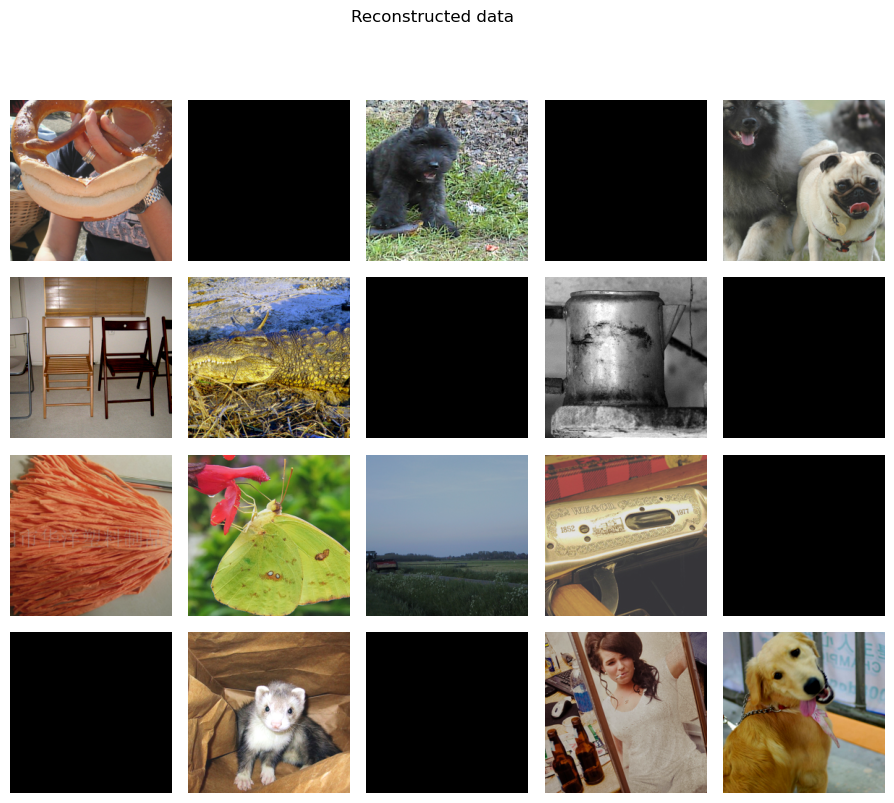

Reconstructed [13/20] images


In [21]:
result = [torch.zeros_like(user_data[0]) for _ in range(20)]

# use imagenet parameters to denormalize samples
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

reconstructed = 0
for i, user_image in enumerate(user_data):
    for n_grad in intermediate:
        n_grad = n_grad * torch.mean(std) + torch.mean(mean)
        if ssim(user_image.unsqueeze(0), n_grad.unsqueeze(0)) > 0.85:
            reconstructed += 1
            result[i] = n_grad
            break
plot20(result, "Reconstructed data")
print(f"Reconstructed [{reconstructed}/20] images")